# Exercise 4

We are going to generate 21 equally spaced values in the interval $ [0,1] $  and calculate the output of the polynomial : 
$$ P(x)=\sum_{j=0}^{n}a_jx^{j} $$ where $ a_j=1 $.

Then, we are going to try and retrieve the coefficients of the polynomial, using different techniques (normal equations, QR, QR with regularization terms, SVD) and discuss the methods and the errors that occur after them.


In [2]:
using Pkg
using LinearAlgebra 
using Plots

First and foremost, we create our polynomial

In [3]:
function p(x::Vector{S},n::Integer) where S<:Real
    y=zeros(length(x))
    for i in 0:n
        y.+=x.^i
    end
    return y
end             

p (generic function with 1 method)

Let's now generate 21 points in the interval $[0,1]$ and calculate the output values from our polynomial. We've assumed a 14-degree polynomial for our problem.

In [4]:
x=collect(LinRange(0,1,21))
y=p(x,14)

21-element Vector{Float64}:
  1.0
  1.0526315789473684
  1.11111111111111
  1.1764705882347788
  1.24999999995904
  1.33333333209157
  1.4285714080729903
  1.538461315562955
  1.6666648770969603
  1.8181703940023473
  1.99993896484375
  2.221938934450316
  2.4988245375385607
  2.852679801460127
  3.3175081283001897
  3.9465461559593678
  4.824078139555841
  6.084305205991654
  7.94108867905351
 10.73417539680493
 15.0

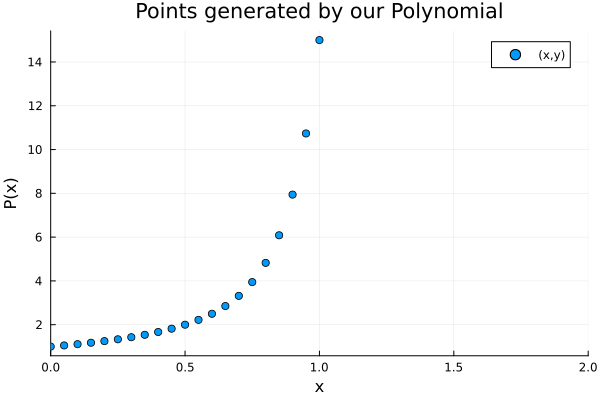

In [5]:
scatter(x,y,label="(x,y)",marker=:circle)
xlabel!("x")
ylabel!("P(x)")
xlims!(0,2)
title!("Points generated by our Polynomial")

We then create a table $A_{21x15}$, where each column holds one power of our data points. 
$$
A_{21x15}=
\begin{bmatrix}
1 & x_{1} & x_{1}^2 & \cdots & x_{1}^{14} \\
1 & x_{2} & x_{2}^2 & \cdots & x_{2}^{14} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_{21} & x_{21}^2 & \cdots & x_{21}^{14} \\
\end{bmatrix}
$$

In [6]:
function Vandermonde(data_points::Integer,n::Integer,x::Vector{S}) where S<:Real
    A=zeros(data_points,n+1)
    for i in 0:n
        A[:,i+1]=x.^i
    end
    return A
end
A=Vandermonde(21,14,x)

21×15 Matrix{Float64}:
 1.0  0.0   0.0     0.0       0.0         …  0.0         0.0
 1.0  0.05  0.0025  0.000125  6.25e-6        1.2207e-17  6.10352e-19
 1.0  0.1   0.01    0.001     0.0001         1.0e-13     1.0e-14
 1.0  0.15  0.0225  0.003375  0.00050625     1.9462e-11  2.91929e-12
 1.0  0.2   0.04    0.008     0.0016         8.192e-10   1.6384e-10
 1.0  0.25  0.0625  0.015625  0.00390625  …  1.49012e-8  3.72529e-9
 1.0  0.3   0.09    0.027     0.0081         1.59432e-7  4.78297e-8
 1.0  0.35  0.1225  0.042875  0.0150062      1.18273e-6  4.13955e-7
 1.0  0.4   0.16    0.064     0.0256         6.71089e-6  2.68435e-6
 1.0  0.45  0.2025  0.091125  0.0410063      3.10286e-5  1.39629e-5
 1.0  0.5   0.25    0.125     0.0625      …  0.00012207  6.10352e-5
 1.0  0.55  0.3025  0.166375  0.0915063      0.00042142  0.000231781
 1.0  0.6   0.36    0.216     0.1296         0.00130607  0.000783642
 1.0  0.65  0.4225  0.274625  0.178506       0.00369721  0.00240318
 1.0  0.7   0.49    0.343     0

# Normal Equations

First, we are going to solve our problem with the normal equations. We compute $B=A^{T}A$ and perfom the Cholesky Decomposition for the matrix $B$.

We then, need to solve two linear systems, $Lz=y$ and $L^{T}w=z$. 

  1.751967 seconds (2.58 M allocations: 173.030 MiB, 3.99% gc time, 99.37% compilation time)


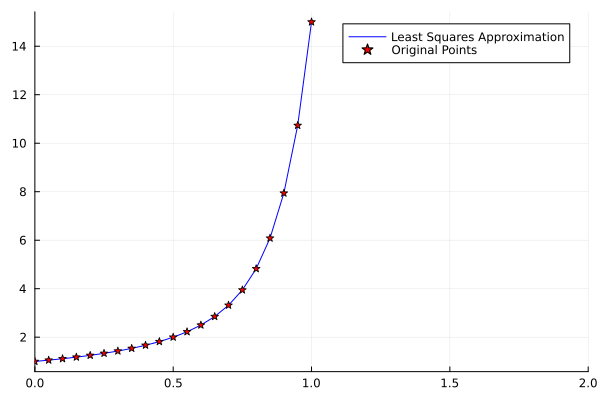

In [7]:
@time begin
    B=A'A
    y_ls=A'*y
    B=cholesky(B)
    
    L=B.L    
    #Let z be z=Uw, so we are solving for Lz=y
    z=L\y_ls
    
    #And finally our w's
    w=L'\z
end 

plot(x,A*w,label="Least Squares Approximation", color="blue")
scatter!(x,y,label="Original Points", marker=:star,color="red") 
xlims!(0,2)

In [8]:
a=ones(15,1)
error=w-a
print("The Eucledian norm of the relative error, using the Normal Equations is: ",norm(error/a))

The Eucledian norm of the relative error, using the Normal Equations is: 6.892327722607687

# Least Squares with QR decomposition

We now need to perform the QR decomposition of Α and solve $R^{T}Rw=R^{T}Q^{T}y$ which means that we only have to solve the triangular system: $Rw=Q^{T}y$. 

  0.102150 seconds (56.78 k allocations: 3.689 MiB, 91.65% compilation time)


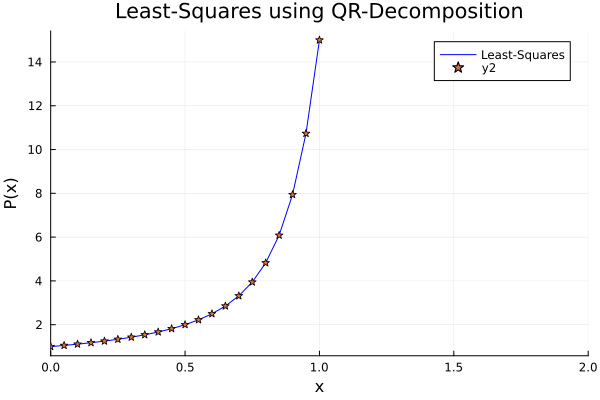

In [9]:
@time begin
    #Let's perform the QR decomposition
    K=qr(A)
    Q=Matrix(K.Q)
    R=Matrix(K.R)
    
    #Compute Q^T*y and solve for our coefficients
    z=Q'y
    w=R\z
end

plot(x,A*w,label="Least-Squares",color="blue")
title!("Least-Squares using QR-Decomposition")
xlims!(0,2)
xlabel!("x")
ylabel!("P(x)")
scatter!(x,y,marker=:star)

In [10]:
a=ones(15,1)
error=w-a
println("The Eucledian norm of the relative error, using QR-Decomposition is: ",norm(error/a))

The Eucledian norm of the relative error, using QR-Decomposition is: 3.070413507971315e-6


# QR with regularization terms

  0.000119 seconds (12 allocations: 19.094 KiB)


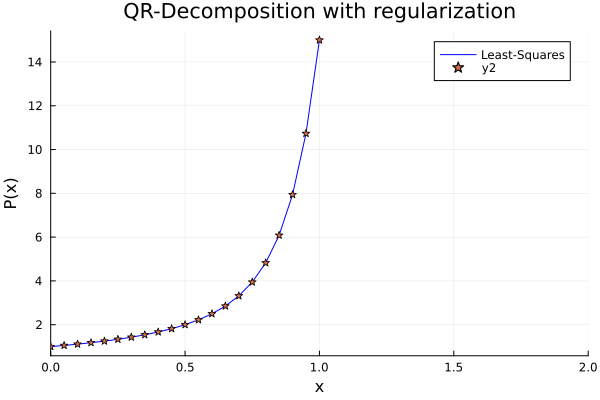

In [11]:
#Let's construct the expanded matrix
alpha=1e-7
I_n=alpha*I(15)
B=vcat(A,I_n)

#We also need to stack zeros in our target vector
t=zeros(15)
y_new=vcat(y,t)


@time begin
    #Decompose the matrix into QR
    K=qr(B)
    Q=Matrix(K.Q)
    R=Matrix(K.R)
    
    #Compute Q^T*y and solve for our coefficients
    z=Q'y_new
    w=R\z
end 

plot(x,A*w,label="Least-Squares",color="blue")
title!("QR-Decomposition with regularization")
xlims!(0,2)
xlabel!("x")
ylabel!("P(x)")
scatter!(x,y,marker=:star)


In [12]:
a=ones(15,1)
error=w-a
println("The Eucledian norm of the relative error, using QR-Decomposition and regularization is: ",norm(error/a))

The Eucledian norm of the relative error, using QR-Decomposition and regularization is: 3.792245157069393e-9


# SVD with the 12 first singular values

  0.222750 seconds (147.13 k allocations: 10.043 MiB, 95.69% compilation time)


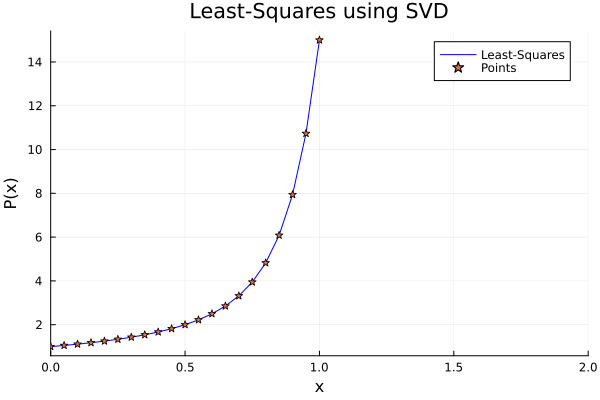

In [13]:
@time begin
    B=svd(A,full=false)
    U=B.U[:,1:12]
    sigma=Diagonal(B.S[1:12])
    Vt=B.Vt[1:12,:]
    
    y_ls=sigma*U'y
    
    z=(sigma*sigma)\y_ls
    w=Vt\z
end
plot(x,A*w,label="Least-Squares",color="blue")
title!("Least-Squares using SVD")
xlims!(0,2)
xlabel!("x")
ylabel!("P(x)")
scatter!(x,y,label="Points",marker=:star)


In [14]:
a=ones(15,1)
error=w-a
println("The Eucledian norm of the relative error, using SVD is: ",norm(error/a))

The Eucledian norm of the relative error, using SVD is: 7.826774120785454e-10


In [15]:
function polynomial(coeffs, x)
    return sum(coeffs[i] * x^(i-1) for i in 1:length(coeffs))
end

polynomial (generic function with 1 method)

# Least-Squares with Constraints using QR factorizations
Suppose we have the points $(1,1)$ $(2,2)$ $(4,3)$ $(5,4)$ $(6,5)$ $(7,4)$ $(9,5)$ and $(10,6)$. We want to fit a 4-th degree polynomial to these point with the constraints that our polynomial passes exactly, from $(4,3)$ $(6,5)$ $(10,6)$.  

Let $A$ be the Vandermonde matrix of our x-values, and $C$ the Vandermonde matrix of our constraints values. So the concatenated matrix is going to be $M = \begin{bmatrix}
A \\
C
\end{bmatrix}$ .

We are now going to solve the constrained LS, using QR factorizations. First we need to compute the QR factorization for $M = \begin{bmatrix}
A \\
C
\end{bmatrix}=\begin{bmatrix}Q_1\\Q_2\end{bmatrix}R$.

If we take the KKT equation and the constraint $Cx=d$, and substitute with the appropriate factorizations the algorithm goes as followed:

1. Compute the QR factorizations
   $M = \begin{bmatrix}
A \\
C
\end{bmatrix}=\begin{bmatrix}Q_1\\Q_2\end{bmatrix}R$ and  $Q_2^{T}=\tilde{Q}\tilde{R}$
2. Compute $\tilde{R}^{-T}x=d$ by forward substitution.
   
3. Form right-hand side and solve
$\tilde{R}w = 2\tilde{Q}^{T}Q_1^{T}b-2\tilde{R}^{-T}d$ via back substitution.

4. Compute $\tilde{x}$. Form right-hand side and solve
$R\tilde{x} = Q_1^{T}-\frac{1}{2}Q_2^{T}w $ by back substitution.

The polynomial coefficients: [4.71580472985198, -5.032406826743829, 2.0372582698087074, -0.2679192738455187, 0.011580171040223429]
The Lagrange multipliers: [-2.8358766392128185, -14.672380394944158, -12.227545744666054]



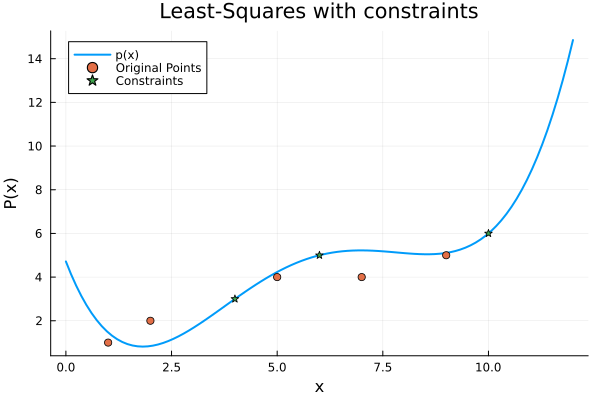

In [30]:
x=[1.0,2.0,5.0,7.0,9.0]
b=[1.0,2.0,4.0,4.0,5.0]

c=[4.0,6.0,10.0]
d=[3.0,5.0,6.0]

#Let's create our matrix A, using the Vandermonde function
A=Vandermonde(length(x),4,x)

#Let's now create our constraints matrix C
C=Vandermonde(length(c),4,c)

#Let's keep the sizes because we are going to extract the orthonomal matrix Q1,Q2
m,n=size(A)
t,n=size(C)

#Using the QR decomposition for the concatenated matrix, and extracting the two orthonormal corresponding to A,C
Q,R=qr([A;C])
Q=Matrix(Q)
Q1=Q[1:m,:]
Q2=Q[m+1:m+t,:]

#We compute the QR factorization for Q2 transpose in order to solve for our lagrange Multipliers
Qtil,Rtil=qr(Q2')
Qtil=Matrix(Qtil)

#Let's find our Lagrange multipliers
lambda=Rtil\((2*Qtil'Q1'*b)-2*(Rtil'\d))

#Finally, let's solve for the feasible solution 
coeffs=R\(Q1'*b-Q2'*lambda/2)

println("The polynomial coefficients: ",coeffs)
println("The Lagrange multipliers: ",lambda)
println("")

x_values = range(0, stop=12, length=100)
y_values = [polynomial(coeffs, i) for i in x_values]

plot(x_values, y_values, label="p(x)", lw=2)
xlabel!("x")
ylabel!("P(x)")
scatter!(x, b, label="Original Points", marker=:circle)
scatter!(c, d, label="Constraints", marker=:star)
title!("Least-Squares with constraints")